# Pose Estimation

**Purpose**: This notebook provides a walk through the process of estimating the position of individuals on an image with a pretrained lightweight OpenPose model proposed in (https://arxiv.org/pdf/1811.12004.pdf). For a more detailed explanation of the OpenPose pipeline, please refer to the original paper (https://arxiv.org/pdf/1812.08008.pdf).

## Package Import

In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import urllib
import os

from models.with_mobilenet import PoseEstimationWithMobileNet
from modules.keypoints import extract_keypoints, group_keypoints
from modules.load_state import load_state
from modules.pose import Pose
from matplotlib import cm
from demo import extract_keypoints, group_keypoints, infer_fast

## Model Description

The Pose Estimation task aims to determine the position of the different body parts of individuals that can be found on an image.

While most of the Multi-Person Pose Estimation approaches have used a top-down strategy, that first detects where the persons are located and then estimates the pose of them at each location, the OpenPose model proposes to solve the task with a bottom-up approach.

A multi-stage CNN outputs confidence maps for body parts locations and vector fields that show the probable locations of body parts connections (limbs). These vector fields are called Part Affinity Fields (PAFs).

<img src="images/openpose_pipeline.png">

The OpenPose pipeline first performs a feature extraction step by feeding the image into a Convolutional Neural Network (CNN), generating a set of feature maps **F**.

<img src="images/openpose-body-architecture-1024x291.png">

In [2]:
if not os.path.exists('model'):
    os.mkdir('model')

urllib.request.urlretrieve(
    "https://download.01.org/opencv/" +\
    "openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth",
                    "model/pretrained.pth")

('model/pretrained.pth', <http.client.HTTPMessage at 0x7f2741778d68>)

In [3]:
net = PoseEstimationWithMobileNet()
checkpoint = torch.load('model/pretrained.pth', map_location='cpu')
load_state(net, checkpoint)
net = net.eval()

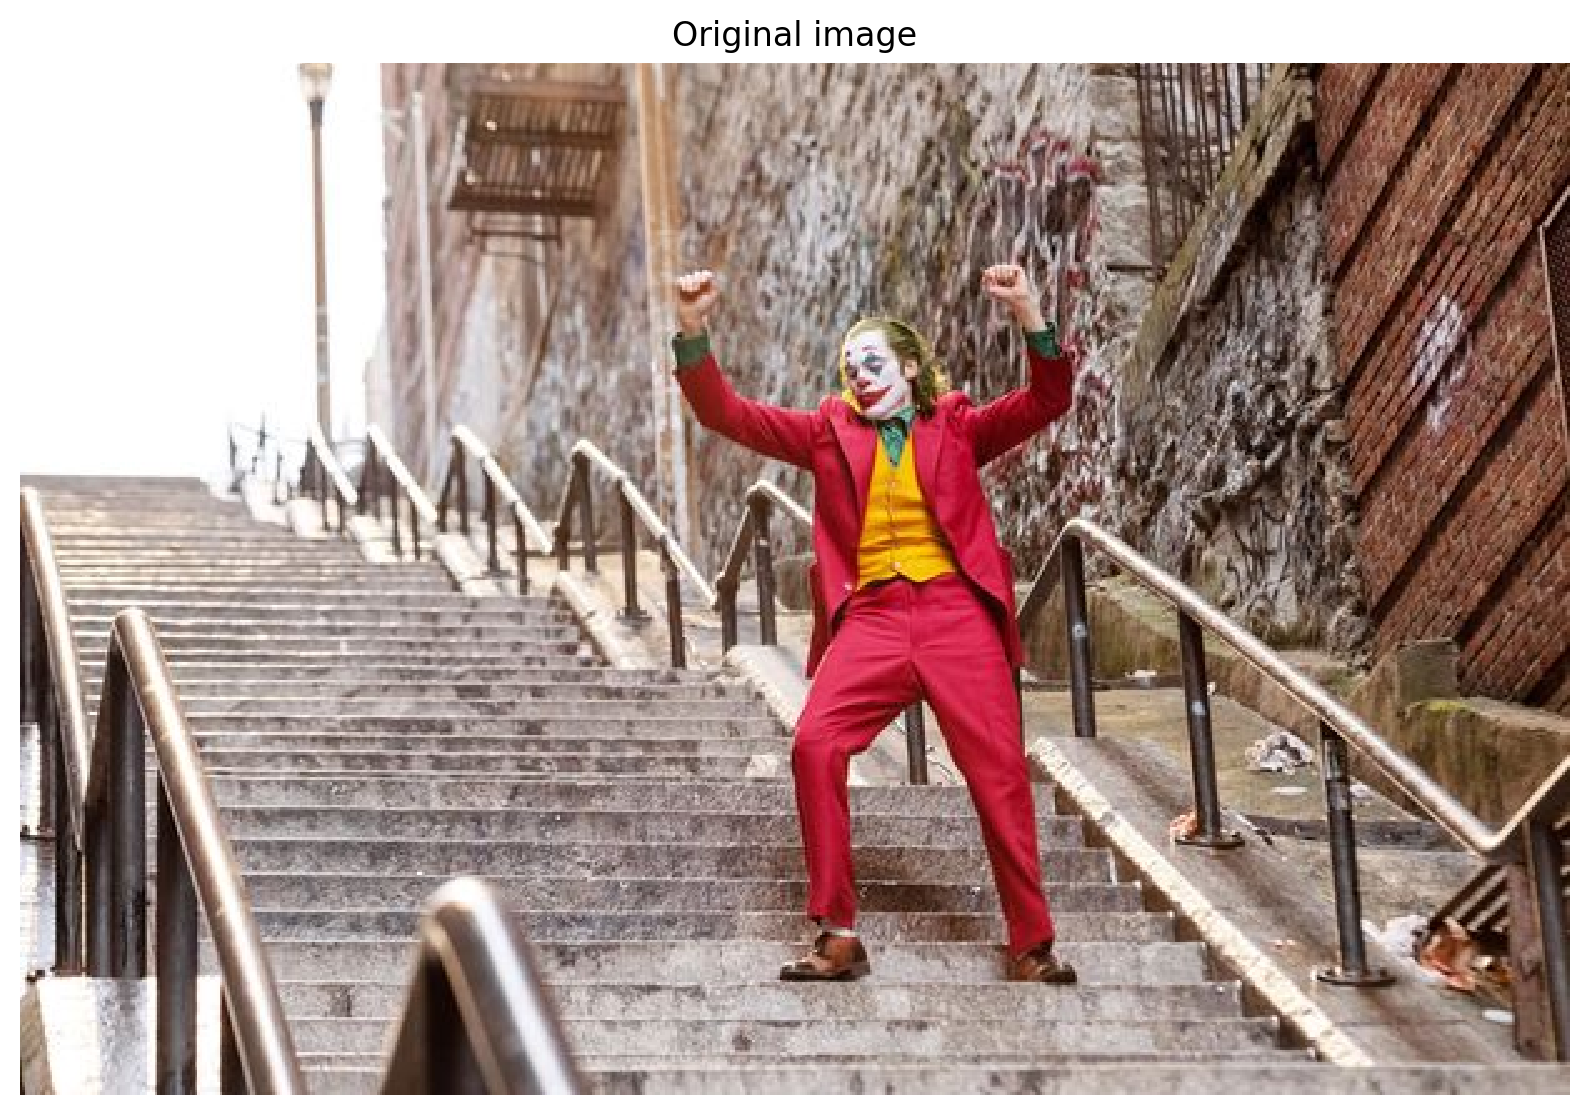

In [4]:
img = cv2.imread('images/joker.jpeg', cv2.IMREAD_COLOR)
img_disp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=[10,10], dpi=200)
plt.title('Original image')
plt.axis('off')
plt.imshow(img_disp)

In [5]:
stride = 8
upsample_ratio = 8
num_keypoints = Pose.num_kpts
orig_img = img.copy()
orig_img_shape = img_disp.shape[1], img_disp.shape[0]

heatmaps, pafs, scale, pad = infer_fast(net, img, 512, stride, upsample_ratio, cpu=True)

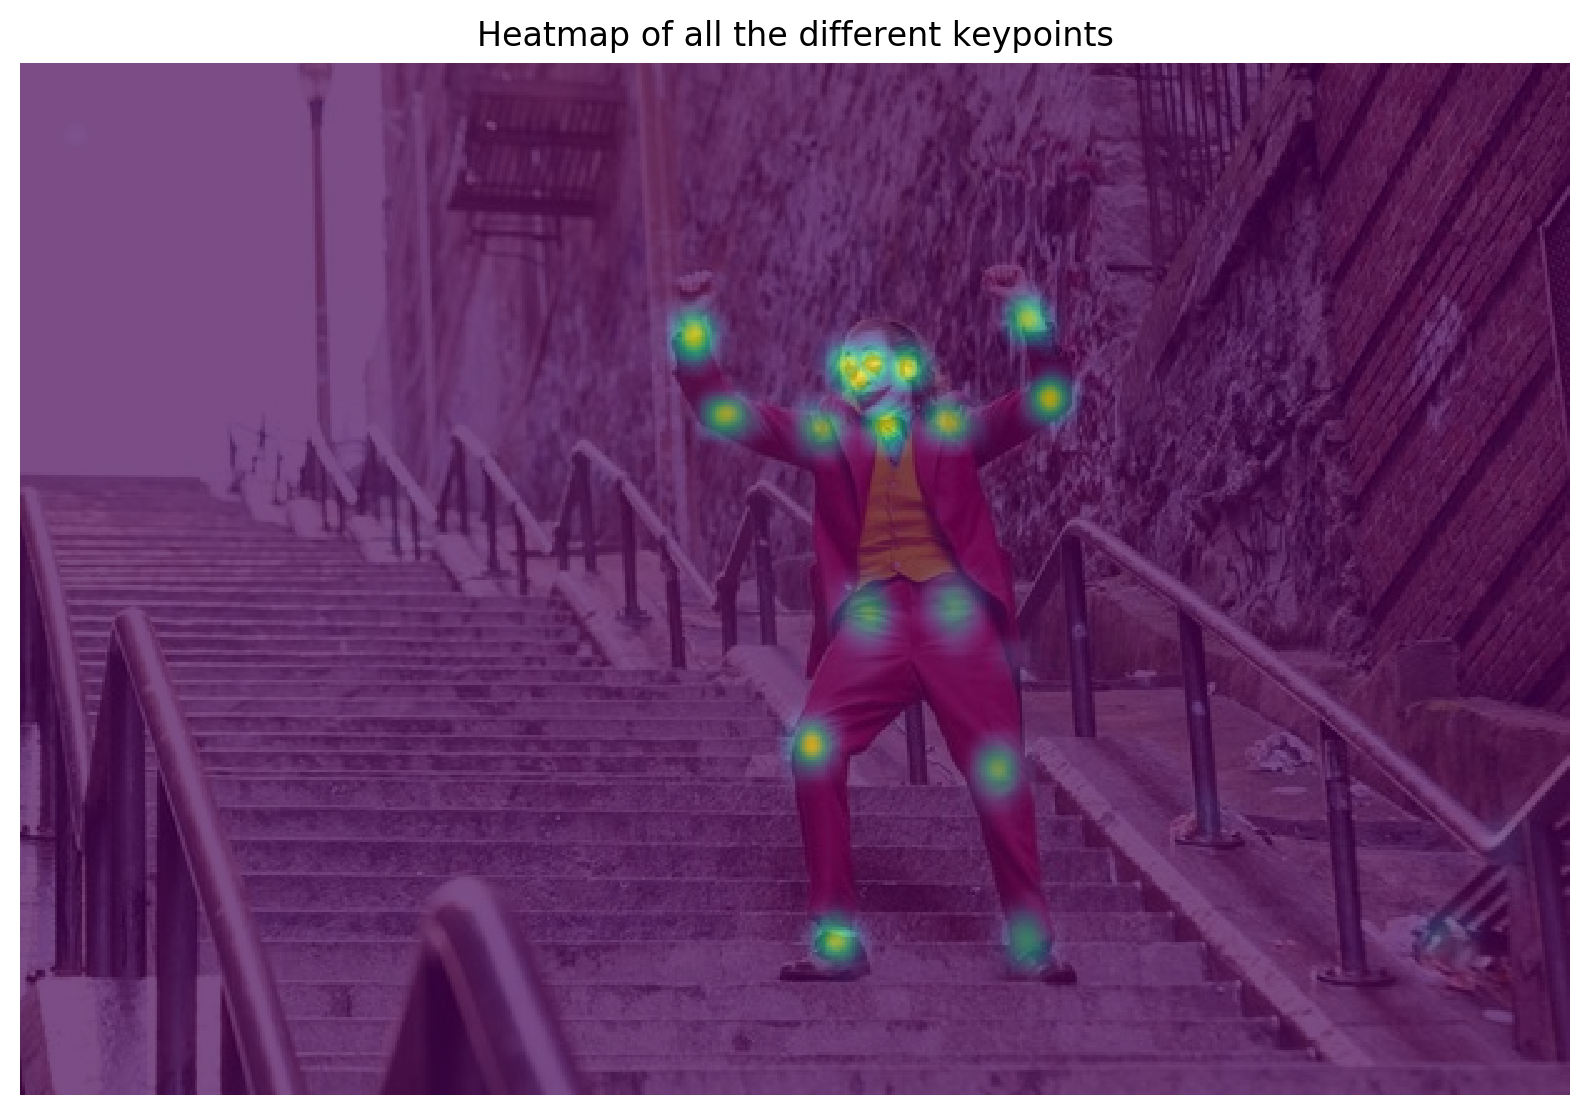

In [6]:
plt.figure(figsize=[10, 10], dpi=200)
plt.title('Heatmap of all the different keypoints')
plt.axis('off')
plt.imshow(cv2.resize(np.max(heatmaps[:,:,:18], axis=2), orig_img_shape))
plt.imshow(img_disp, alpha=0.3)

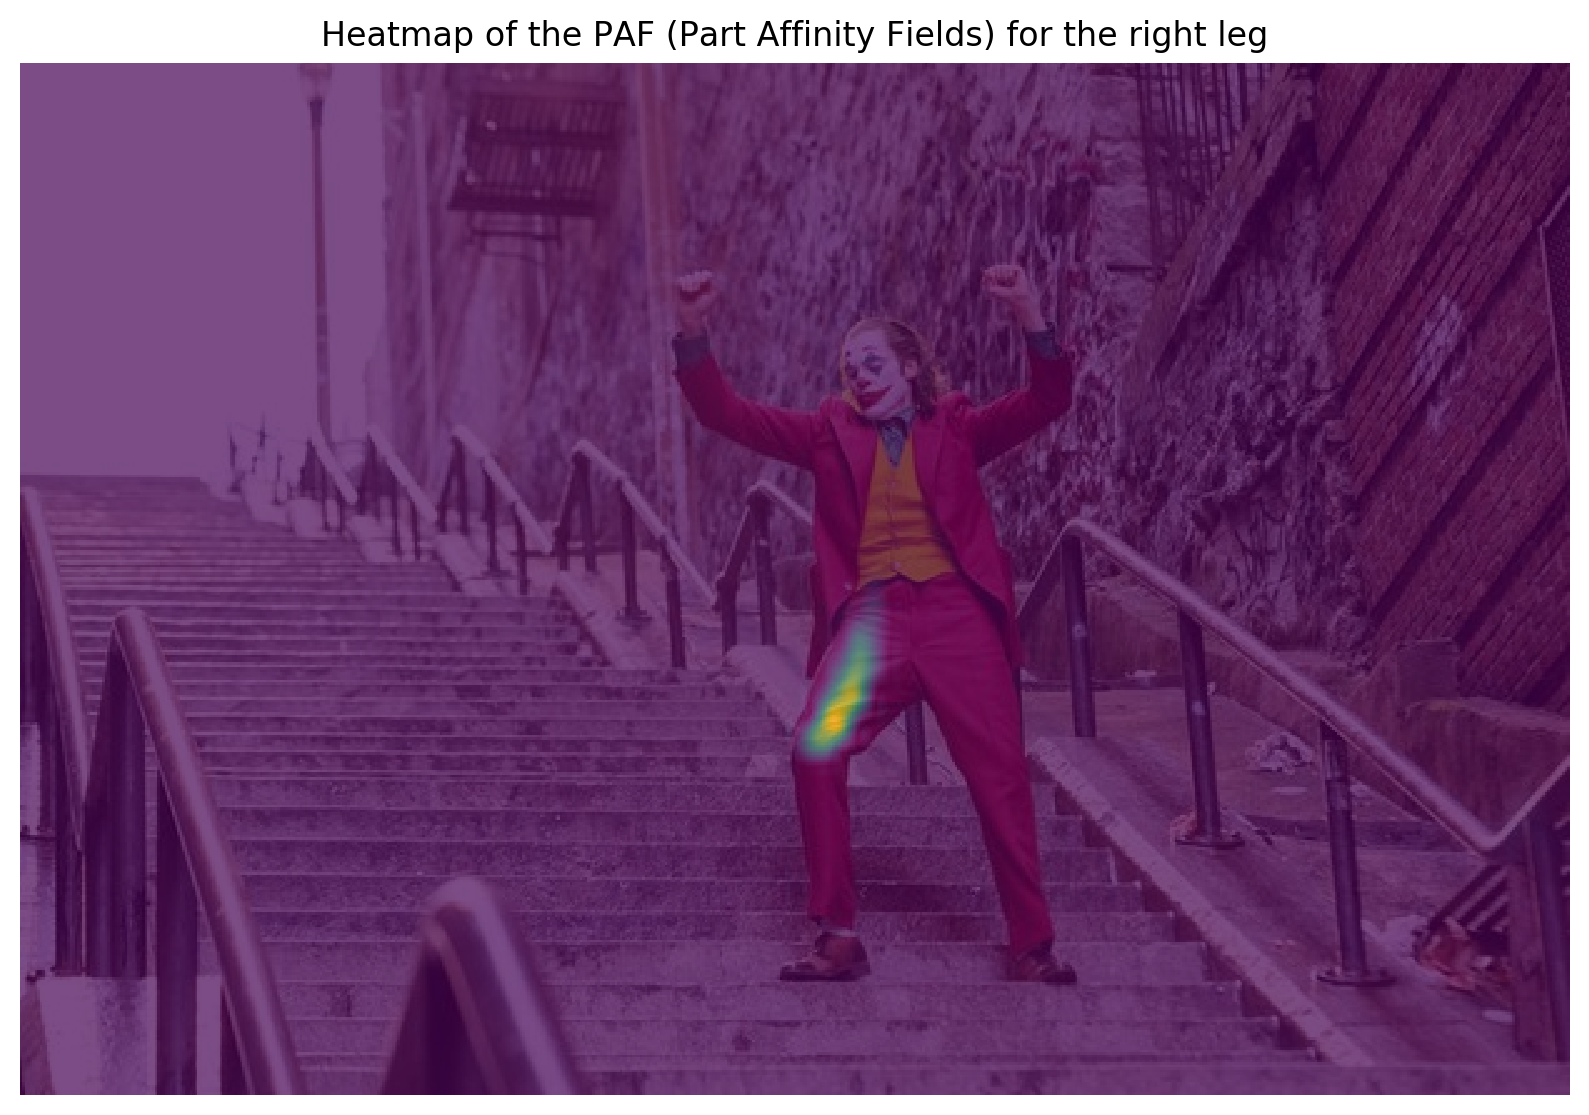

In [7]:
plt.figure(figsize=[10, 10], dpi=200)
plt.title('Heatmap of the PAF (Part Affinity Fields) for the right leg')
plt.axis('off')
plt.imshow(cv2.resize(np.abs(pafs[:,:,2]), orig_img_shape))
plt.imshow(img_disp, alpha=0.3)

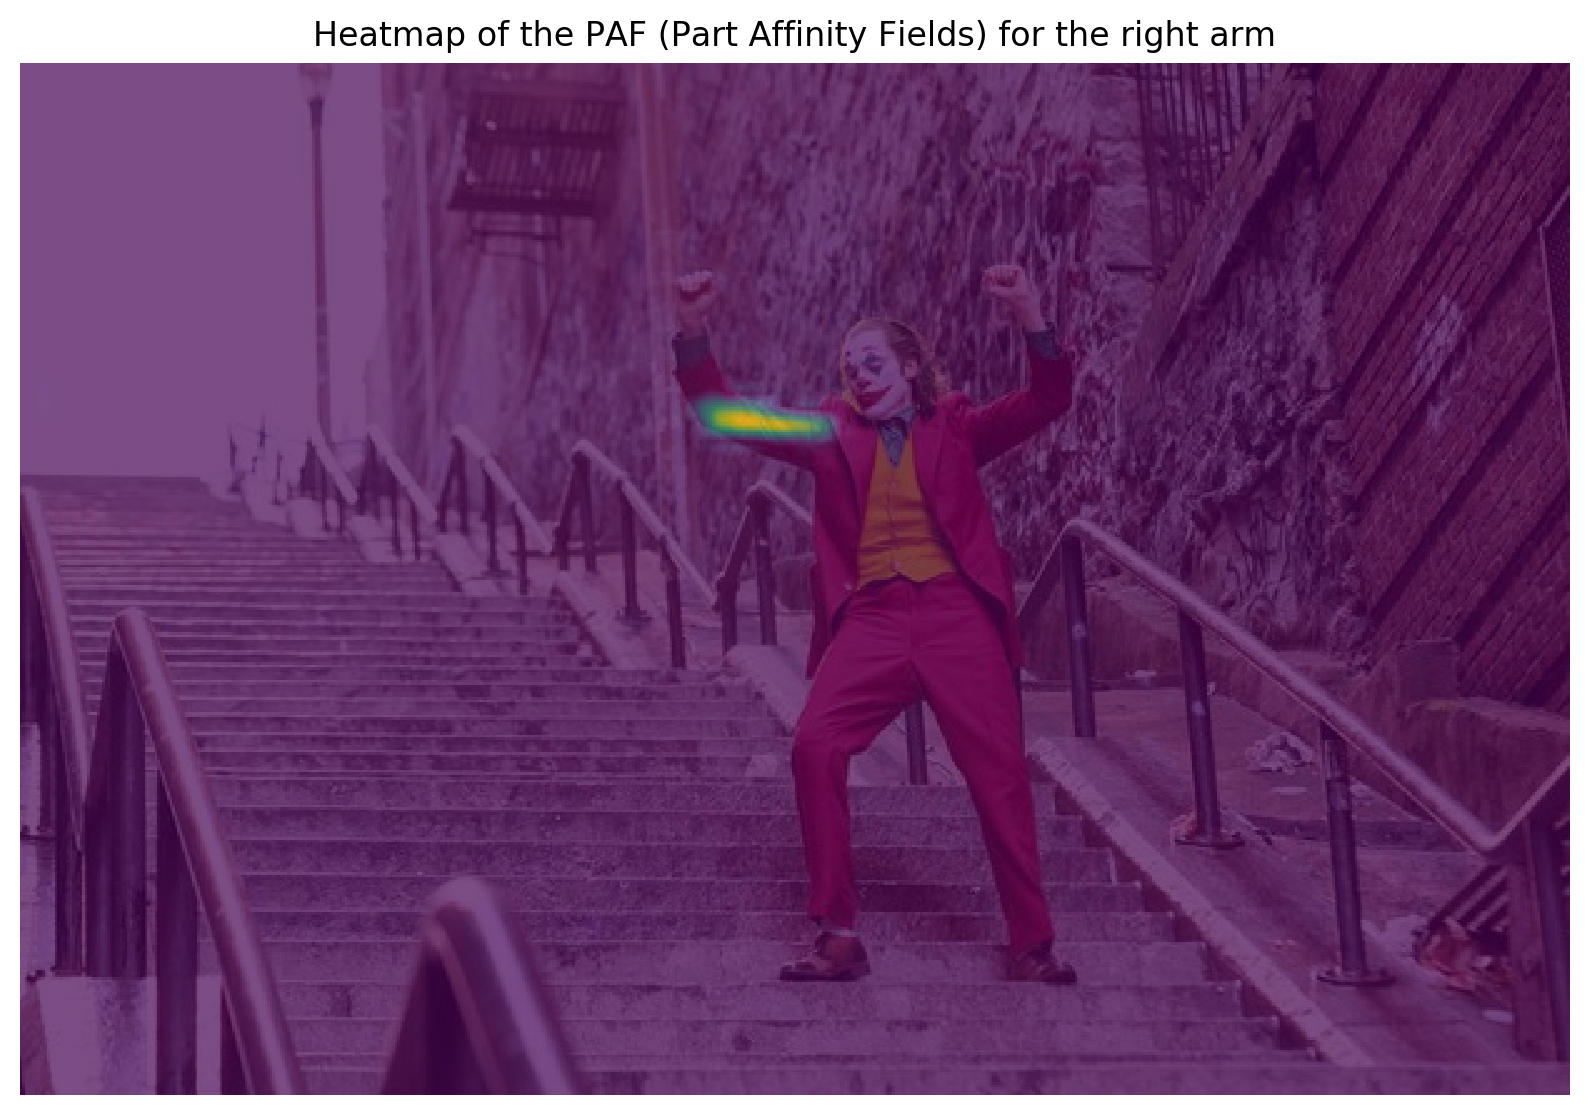

In [8]:
plt.figure(figsize=[10, 10], dpi=200)
plt.title('Heatmap of the PAF (Part Affinity Fields) for the right arm')
plt.axis('off')
plt.imshow(cv2.resize(np.abs(pafs[:,:,14]), orig_img_shape))
plt.imshow(img_disp, alpha=0.3)

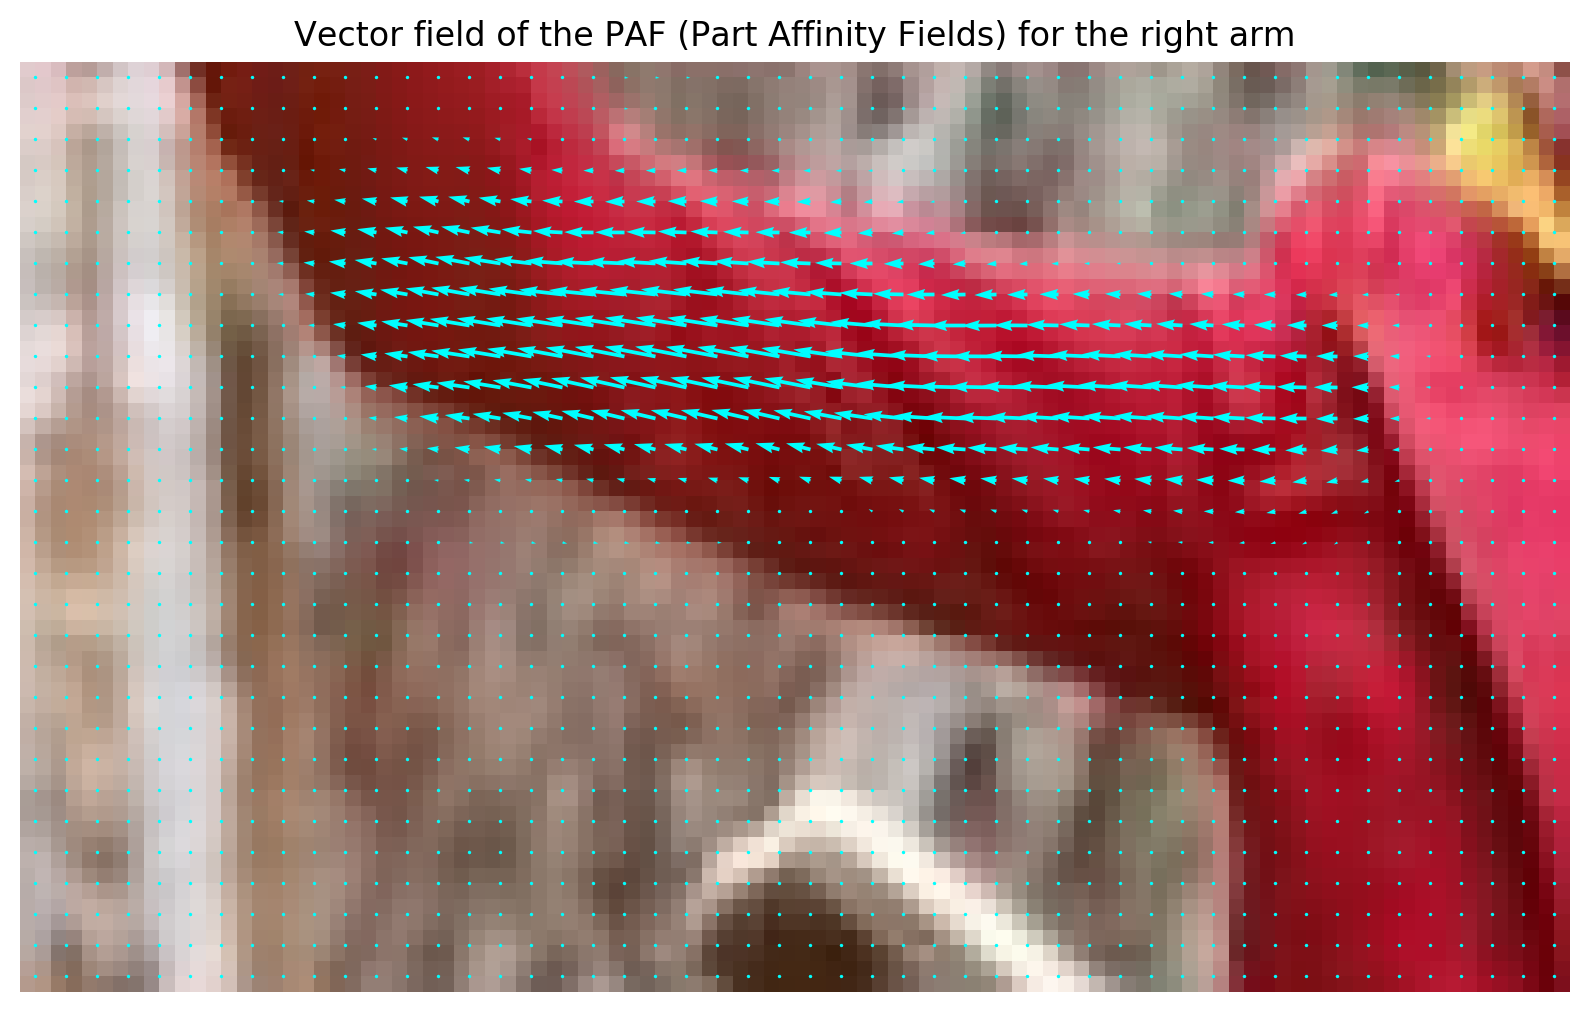

In [9]:
skip=(slice(None,None,2),slice(None,None,2))
plt.figure(figsize=[10, 10], dpi=200)
# pafs_right_arm_vector_field_x = cv2.resize(pafs[:, :, 14][skip], orig_img_shape)
# pafs_right_arm_vector_field_y = cv2.resize(-pafs[:, :, 15][skip], orig_img_shape)


plt.title('Vector field of the PAF (Part Affinity Fields) for the right arm')
plt.axis('off')
plt.quiver(pafs[160:220, 320:420, 14][skip], - pafs[160:220, 320:420, 15][skip], color='cyan',scale=30)
plt.imshow(cv2.resize(img_disp, (776,512))[160:220, 320:420], extent=(-0.5, 50-0.5, 30-0.5, -0.5))

# plt.quiver(pafs_right_arm_vector_field_x[140:160, 250:350],
#            pafs_right_arm_vector_field_y[140:160, 250:350], color='cyan',scale=30)
# plt.imshow(img_disp[160:220, 320:420], extent=(-0.5, 50-0.5, 30-0.5, -0.5))

<img src="images/keypoint_extraction.png">

In [10]:
total_keypoints_num = 0
all_keypoints_by_type = []
for kpt_idx in range(num_keypoints):  # 19th for bg
    total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

<img src="images/keypoints.png">

In [11]:
keypoints = {
        0: "nose",
        1: "neck",
        2: "left_shoulder",
        3: "left_elbow",
        4: "left_wrist",
        5: "right_shoulder",
        6: "right_elbow",
        7: "right_wrist",
        8: "left_hip",
        9: "left_knee",
        10: "left_ankle",
        11: "right_hip",
        12: "right_knee",
        13: "right_ankle",
        14: "left_eye",
        15: "right_eye",
        16: "left_ear",
        17: "right_ear",
    }

## Detections analysis

### Number of keypoints per type

In [12]:
[f'{len(x)} keypoints extracted for {keypoints[i]}' for i, x in enumerate(all_keypoints_by_type)]

['1 keypoints extracted for nose',
 '1 keypoints extracted for neck',
 '1 keypoints extracted for left_shoulder',
 '1 keypoints extracted for left_elbow',
 '1 keypoints extracted for left_wrist',
 '1 keypoints extracted for right_shoulder',
 '1 keypoints extracted for right_elbow',
 '1 keypoints extracted for right_wrist',
 '1 keypoints extracted for left_hip',
 '1 keypoints extracted for left_knee',
 '3 keypoints extracted for left_ankle',
 '1 keypoints extracted for right_hip',
 '1 keypoints extracted for right_knee',
 '3 keypoints extracted for right_ankle',
 '1 keypoints extracted for left_eye',
 '1 keypoints extracted for right_eye',
 '0 keypoints extracted for left_ear',
 '1 keypoints extracted for right_ear']

We can see that too many points are detected for the ankles. Let's see how it looks like on the original picture.

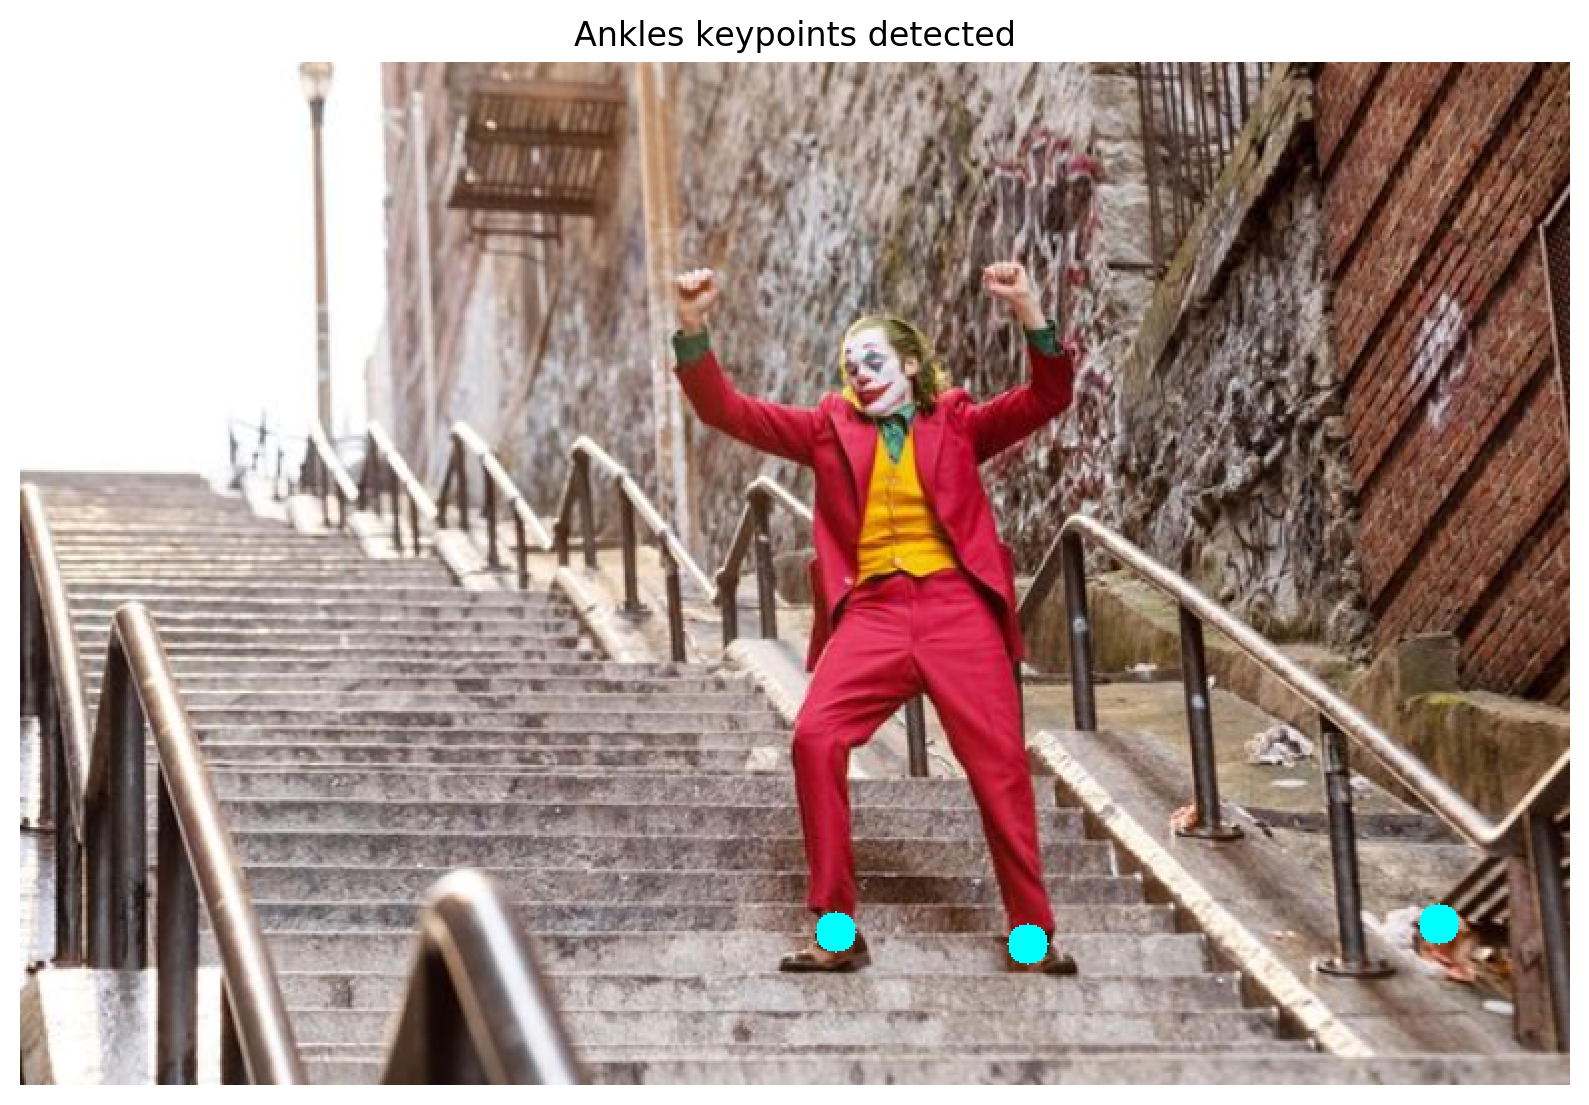

In [13]:
img_with_ankle_keypoints = cv2.resize(img_disp.copy(), (776,512))
for ankle_keypoint in all_keypoints_by_type[10]:
    img_with_ankle_keypoints = cv2.circle(img_with_ankle_keypoints,
                                          ankle_keypoint[:2], 10, color=(0, 255, 255), thickness=-1)

plt.figure(figsize=[10, 10], dpi=200)
plt.title('Ankles keypoints detected')
plt.axis('off')
plt.imshow(img_with_ankle_keypoints)

In [14]:
def get_positions(all_keypoints_by_type, pafs):
    pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs, demo=True)
    for kpt_id in range(all_keypoints.shape[0]):
        all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
        all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
    current_poses = []
    for n in range(len(pose_entries)):
        if len(pose_entries[n]) == 0:
            continue
        pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
        for kpt_id in range(num_keypoints):
            if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
        pose = Pose(pose_keypoints, pose_entries[n][18])
        current_poses.append(pose)
        
    return current_poses

In [15]:
all_positions = get_positions(all_keypoints_by_type, pafs)
colormap = cm.tab10.colors

img_final = img_disp.copy()

for i, pose in enumerate(all_positions):
    pose.draw(img_final, np.array(colormap[i % len(colormap)])*255)

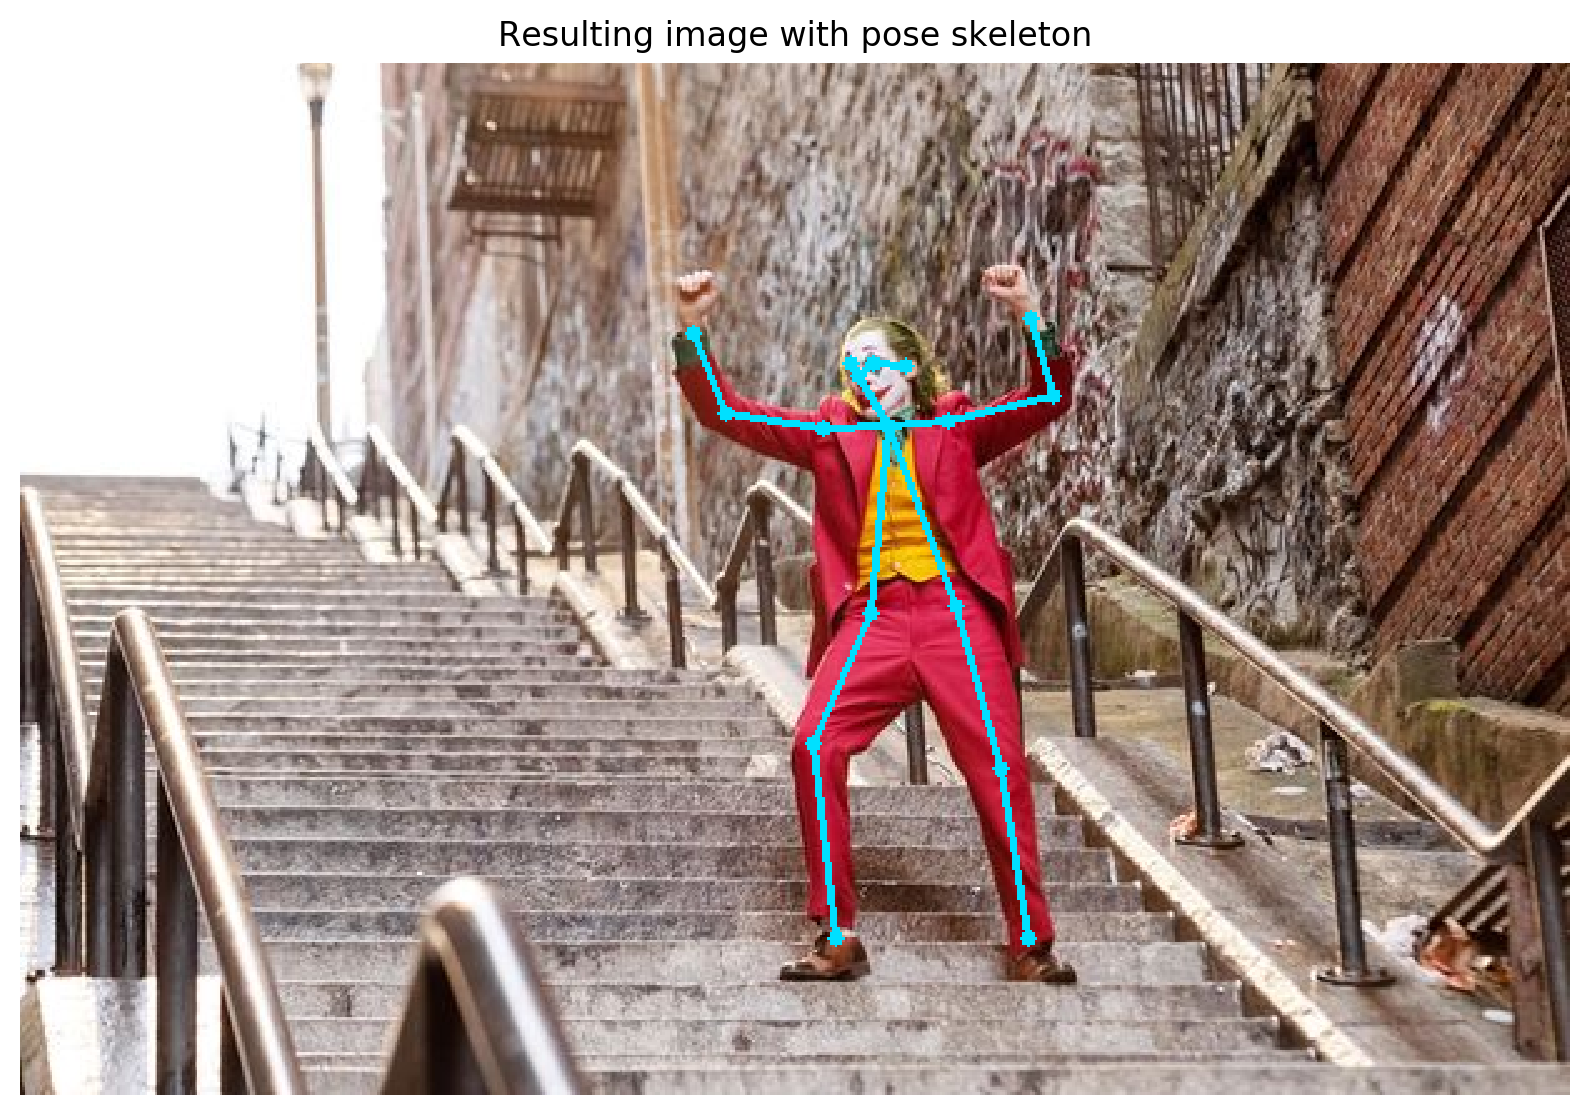

In [16]:
plt.figure(figsize=[10, 10], dpi=200)
plt.title('Resulting image with pose skeleton')
plt.axis('off')
plt.imshow(img_final)